In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.720282795993131
(0, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 13)
(13, 14)
(14, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1047.01it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1068.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.52it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=dataset_train_cost.costs)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.60it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 20), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 100
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e0):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with NNLS

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

(CVXPY) Dec 03 09:50:47 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  68.1897%, Val Regret:  62.8446%


Epoch    9, Loss:  -0.8917:  10%|█████▎                                               | 10/100 [00:11<01:34,  1.05s/it]

Epoch  10, Train Regret:   8.8461%, Val Regret:  11.4308%


Epoch   19, Loss:  -0.9488:  20%|██████████▌                                          | 20/100 [00:21<01:23,  1.05s/it]

Epoch  20, Train Regret:   8.7291%, Val Regret:   9.6488%


Epoch   29, Loss:  -0.9029:  30%|███████████████▉                                     | 30/100 [00:32<01:13,  1.05s/it]

Epoch  30, Train Regret:   7.9487%, Val Regret:  10.9138%


Epoch   39, Loss:  -0.8741:  40%|█████████████████████▏                               | 40/100 [00:43<01:02,  1.05s/it]

Epoch  40, Train Regret:   8.0942%, Val Regret:  10.7728%


Epoch   49, Loss:  -0.8809:  50%|██████████████████████████▌                          | 50/100 [00:53<00:53,  1.08s/it]


Epoch  50, Train Regret:   7.4998%, Val Regret:  11.2504%

Early Stop!

Evaluation:
Test Regret: 9.8195%
Training Elapsed Time: 1.96 Sec


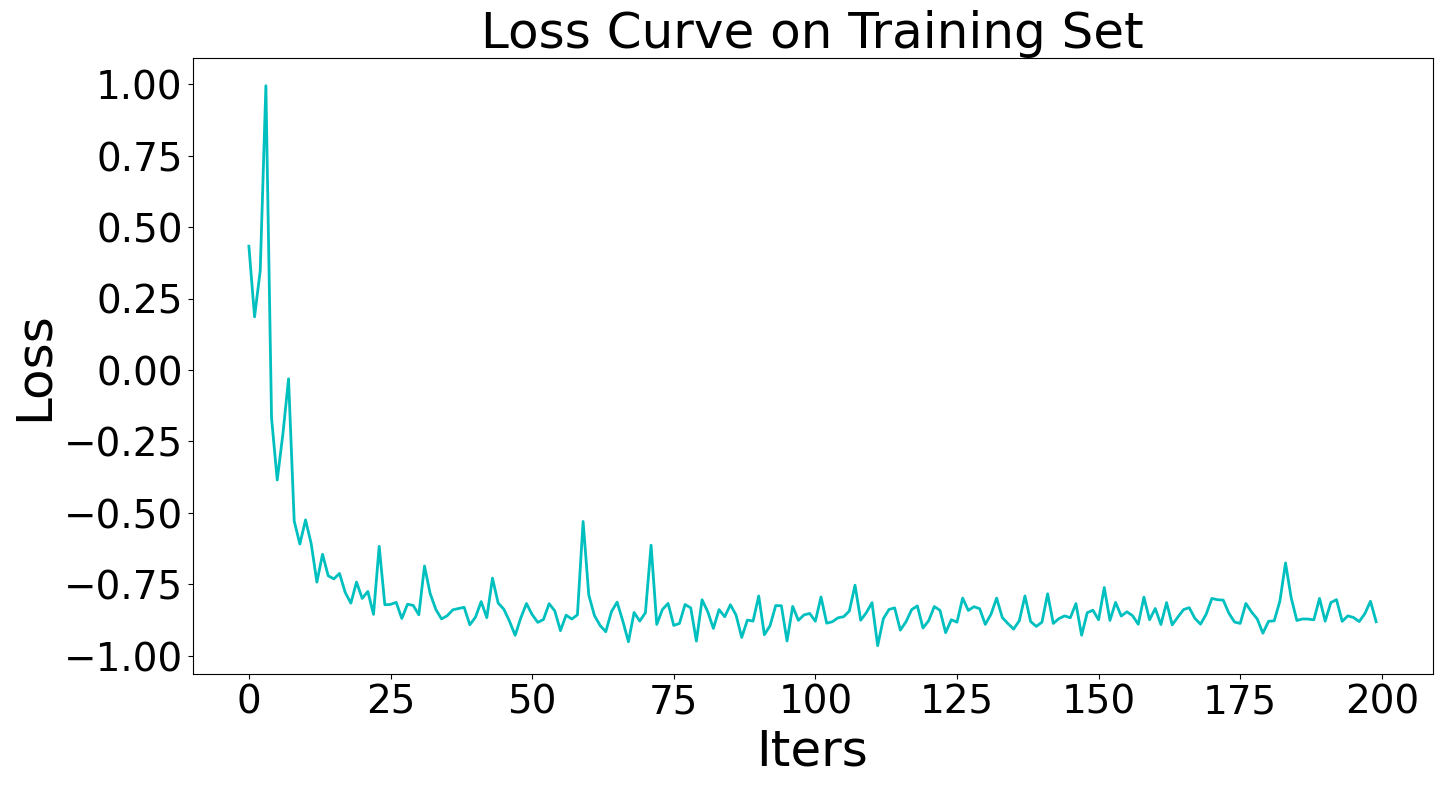

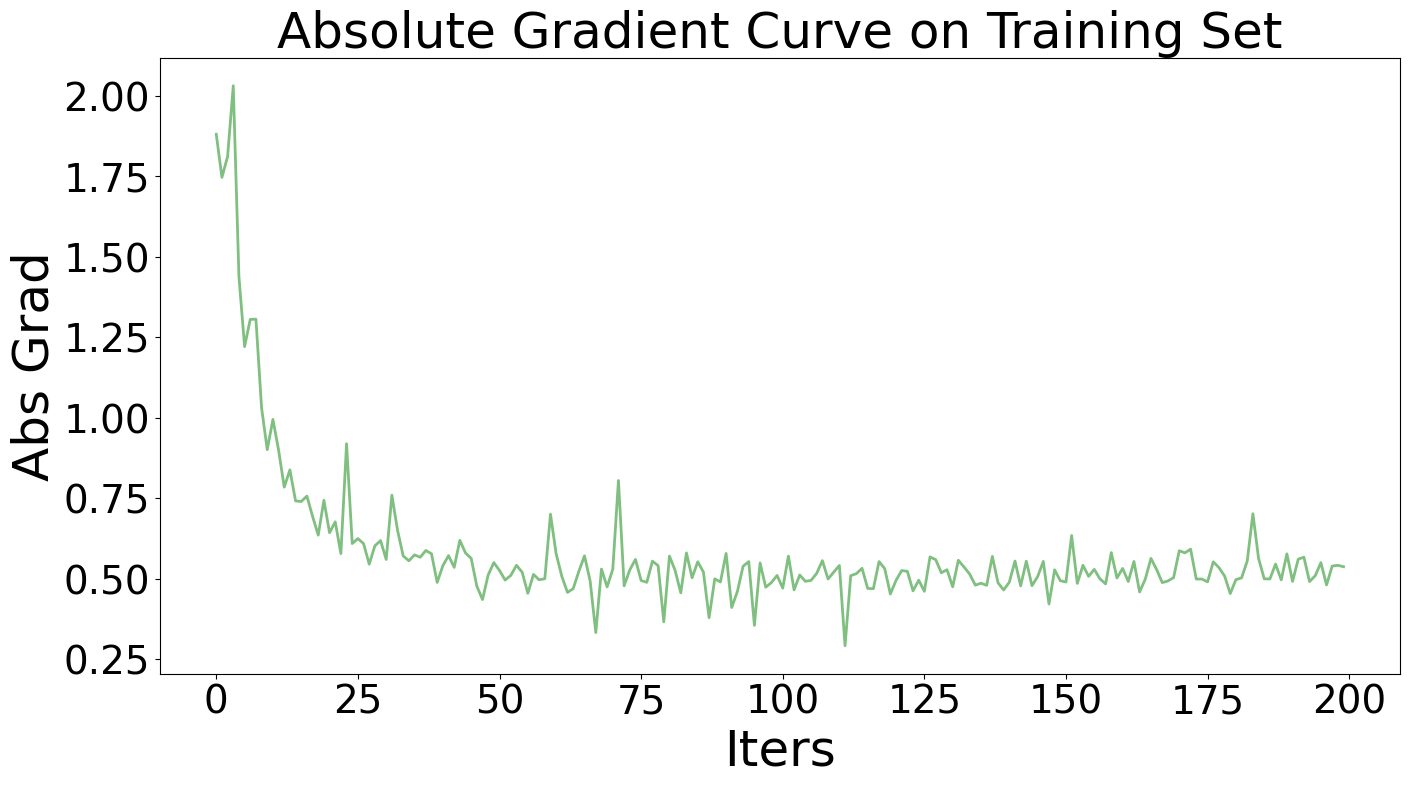

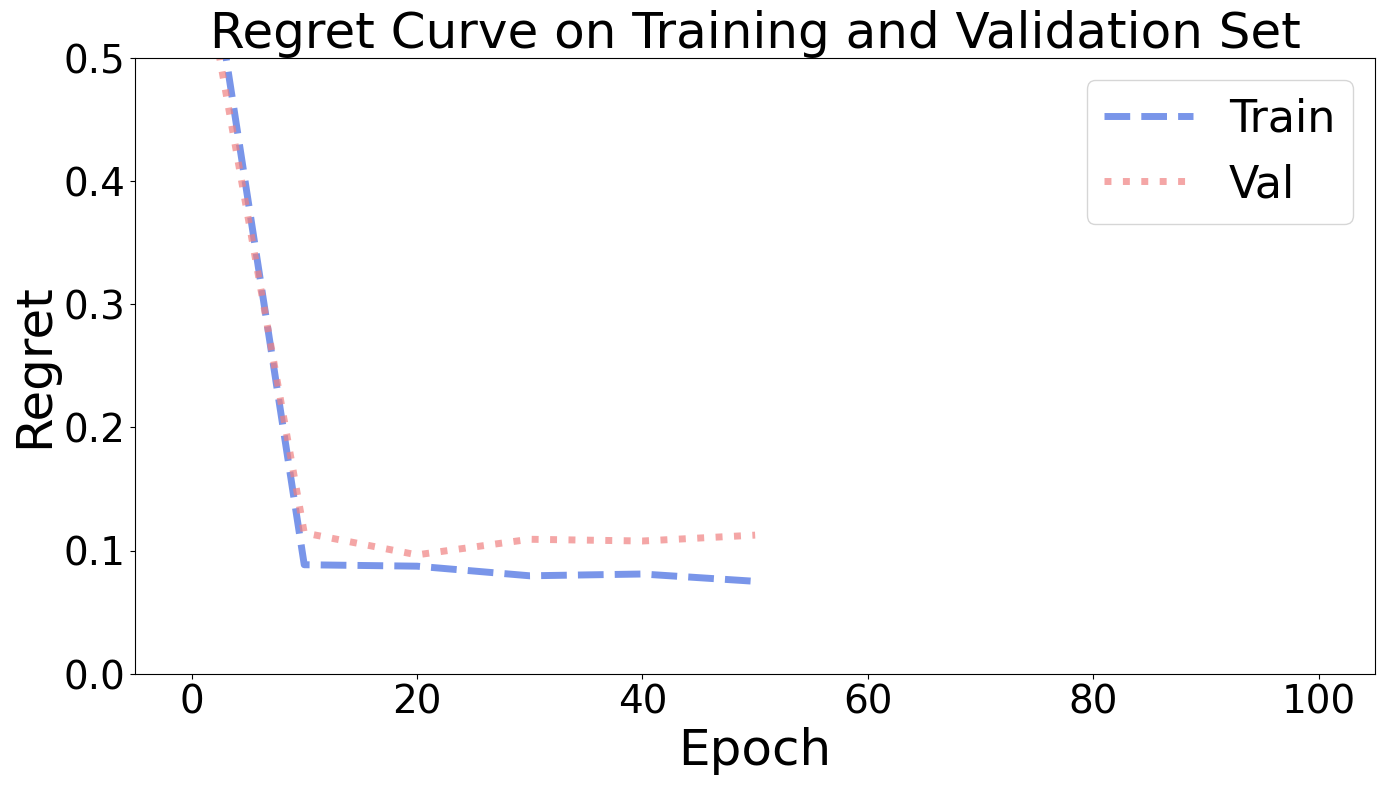

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with NNLS 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [18]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  42.2910%, Val Regret:  43.8754%


Epoch    9, Loss:  -0.8885:  10%|█████▎                                               | 10/100 [00:11<01:34,  1.05s/it]

Epoch  10, Train Regret:   7.7190%, Val Regret:   9.3831%


Epoch   19, Loss:  -0.9491:  20%|██████████▌                                          | 20/100 [00:21<01:24,  1.05s/it]

Epoch  20, Train Regret:   8.8977%, Val Regret:  10.1075%


Epoch   29, Loss:  -0.9015:  30%|███████████████▉                                     | 30/100 [00:32<01:13,  1.05s/it]

Epoch  30, Train Regret:   7.6210%, Val Regret:  10.7557%


Epoch   39, Loss:  -0.8746:  40%|█████████████████████▏                               | 40/100 [00:43<01:04,  1.08s/it]


Epoch  40, Train Regret:   8.0158%, Val Regret:  11.2519%

Early Stop!

Evaluation:
Test Regret: 10.3499%
Training Elapsed Time: 1.68 Sec


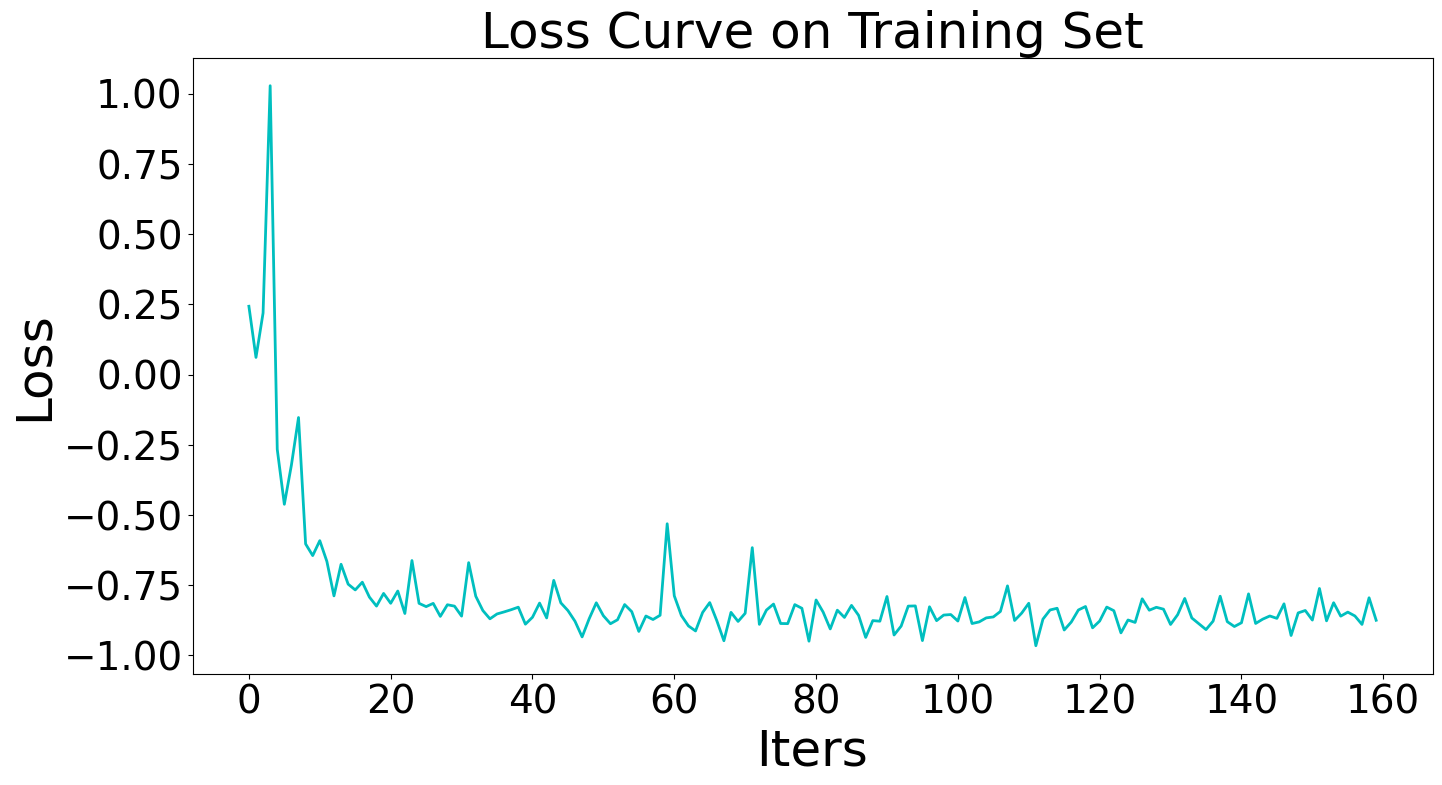

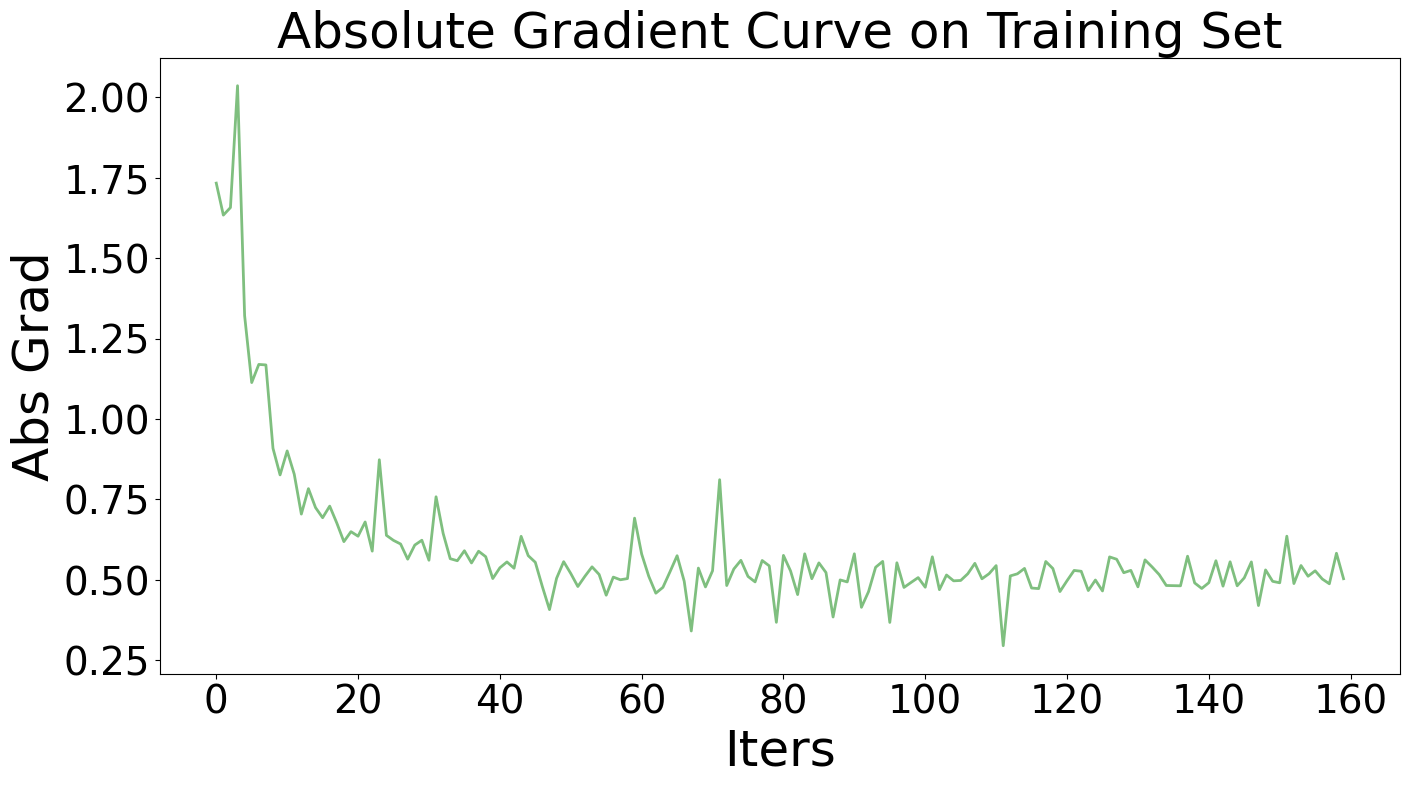

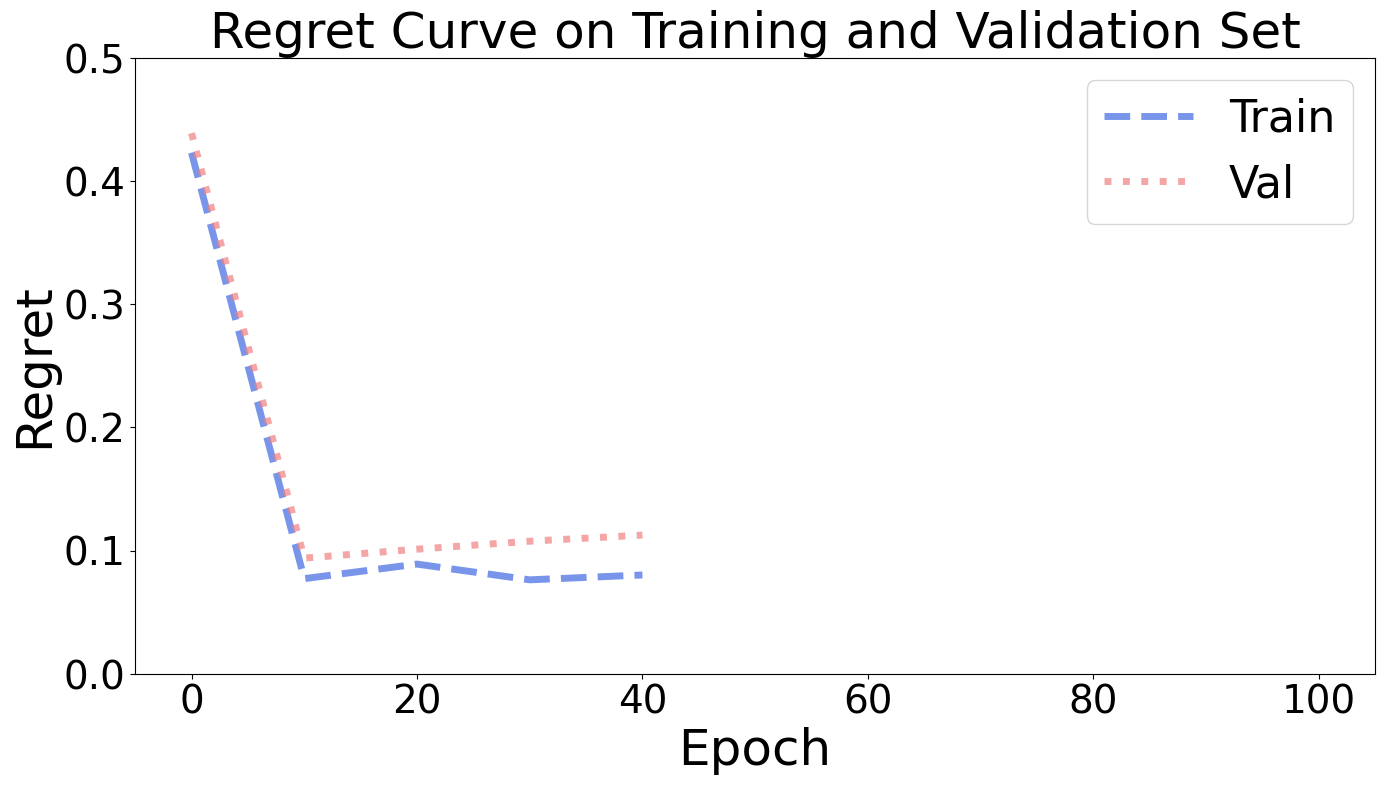

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  59.7089%, Val Regret:  64.5878%


Epoch    9, Loss:  -0.3796:  10%|█████▎                                               | 10/100 [00:10<01:32,  1.03s/it]

Epoch  10, Train Regret:  23.7566%, Val Regret:  21.9643%


Epoch   19, Loss:  -0.4437:  20%|██████████▌                                          | 20/100 [00:21<01:22,  1.03s/it]

Epoch  20, Train Regret:  10.3534%, Val Regret:  11.4836%


Epoch   29, Loss:  -0.6066:  30%|███████████████▉                                     | 30/100 [00:31<01:12,  1.03s/it]

Epoch  30, Train Regret:   7.5131%, Val Regret:   9.9882%


Epoch   39, Loss:  -0.5289:  40%|█████████████████████▏                               | 40/100 [00:42<01:01,  1.03s/it]

Epoch  40, Train Regret:   7.0744%, Val Regret:  10.9166%


Epoch   49, Loss:  -0.5693:  50%|██████████████████████████▌                          | 50/100 [00:53<00:51,  1.03s/it]

Epoch  50, Train Regret:   7.1609%, Val Regret:  10.8289%


Epoch   59, Loss:  -0.6786:  60%|███████████████████████████████▊                     | 60/100 [01:03<00:42,  1.06s/it]


Epoch  60, Train Regret:   7.0015%, Val Regret:  10.1877%

Early Stop!

Evaluation:
Test Regret: 9.8469%
Training Elapsed Time: 1.36 Sec


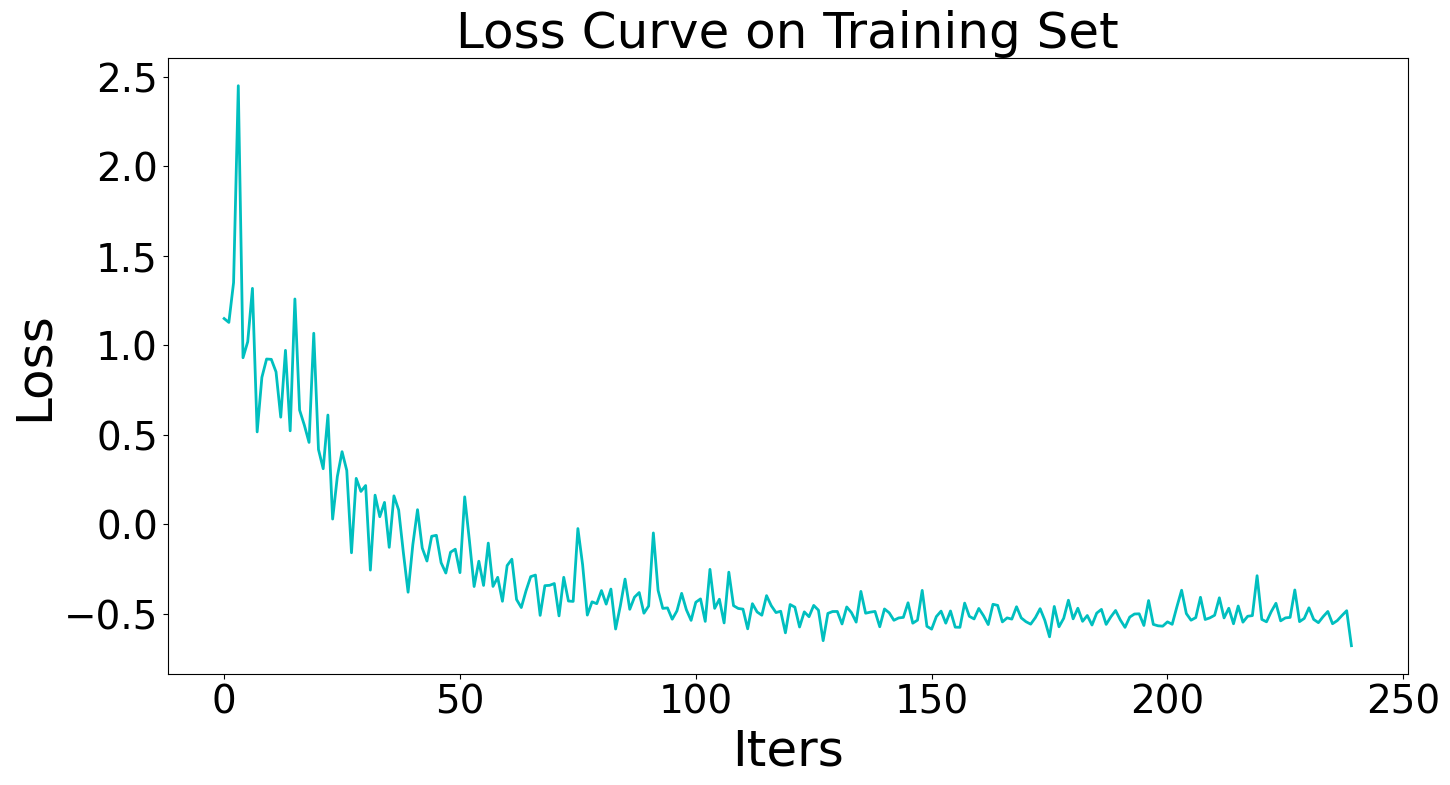

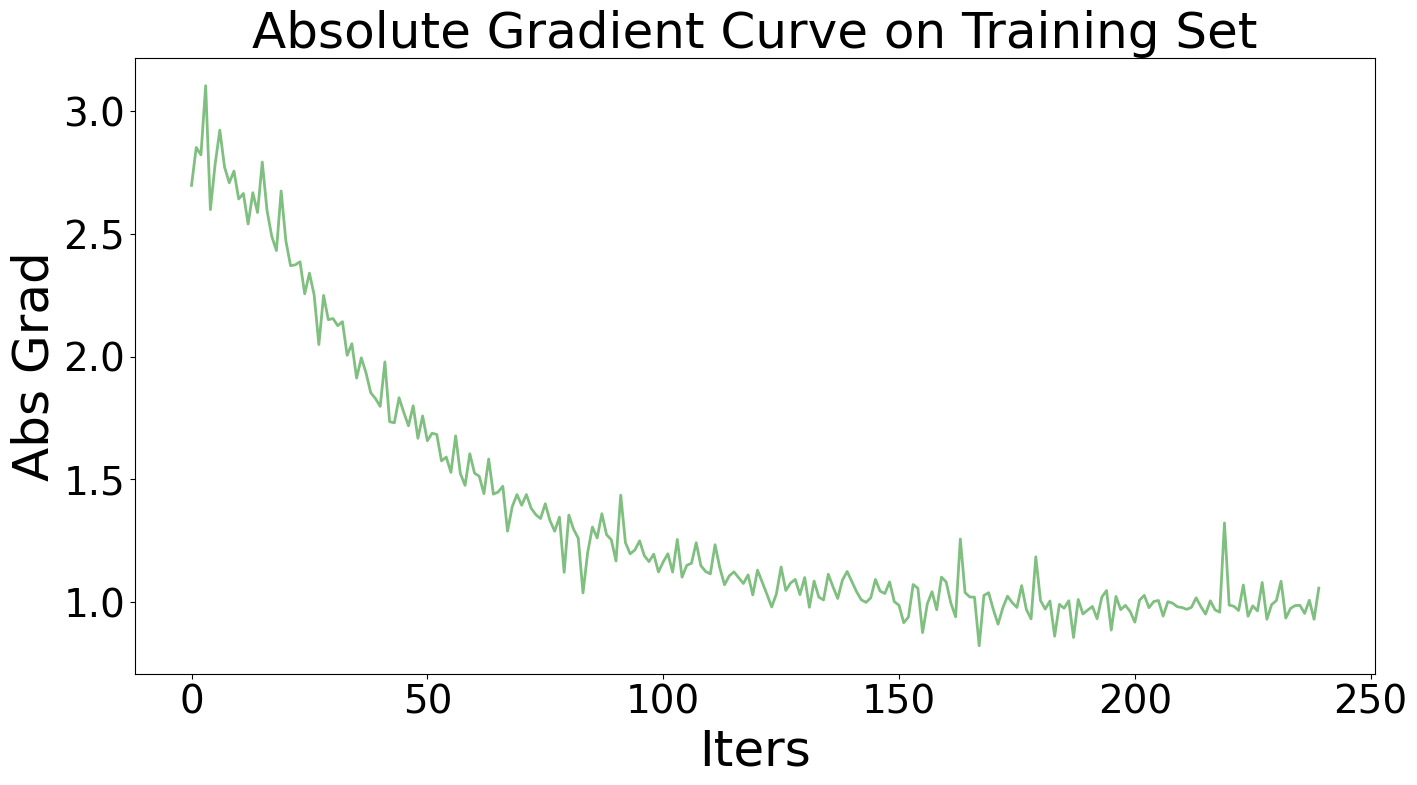

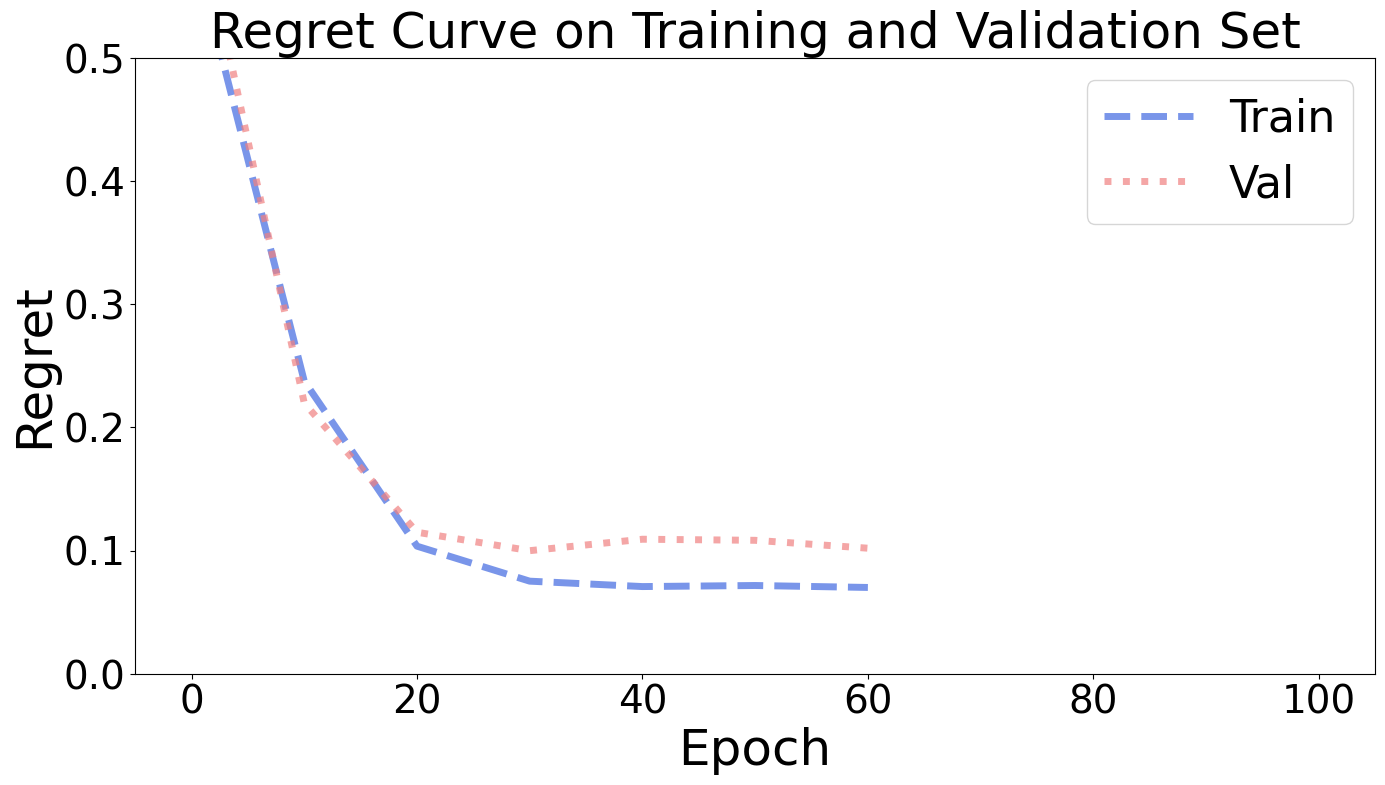

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  65.1412%, Val Regret:  64.5520%


Epoch    9, Loss:  -0.3259:  10%|█████▎                                               | 10/100 [00:12<01:45,  1.18s/it]

Epoch  10, Train Regret:  20.2561%, Val Regret:  25.0265%


Epoch   19, Loss:  -0.5499:  20%|██████████▌                                          | 20/100 [00:24<01:34,  1.18s/it]

Epoch  20, Train Regret:   9.6082%, Val Regret:  14.3066%


Epoch   29, Loss:  -0.9186:  30%|███████████████▉                                     | 30/100 [00:36<01:23,  1.19s/it]

Epoch  30, Train Regret:   7.9558%, Val Regret:  11.1096%


Epoch   39, Loss:  -0.7774:  40%|█████████████████████▏                               | 40/100 [00:48<01:10,  1.18s/it]

Epoch  40, Train Regret:   6.9012%, Val Regret:  10.8306%


Epoch   49, Loss:  -0.7462:  50%|██████████████████████████▌                          | 50/100 [01:00<01:00,  1.21s/it]

Epoch  50, Train Regret:   6.9548%, Val Regret:  10.5820%


Epoch   59, Loss:  -0.8864:  60%|███████████████████████████████▊                     | 60/100 [01:12<00:47,  1.18s/it]

Epoch  60, Train Regret:   6.8462%, Val Regret:   9.2975%


Epoch   69, Loss:  -0.7425:  70%|█████████████████████████████████████                | 70/100 [01:24<00:35,  1.18s/it]

Epoch  70, Train Regret:   7.7751%, Val Regret:   9.4660%


Epoch   79, Loss:  -0.6918:  80%|██████████████████████████████████████████▍          | 80/100 [01:36<00:23,  1.19s/it]

Epoch  80, Train Regret:   6.1393%, Val Regret:  10.9641%


Epoch   89, Loss:  -0.9318:  90%|███████████████████████████████████████████████▋     | 90/100 [01:48<00:12,  1.21s/it]


Epoch  90, Train Regret:   6.3835%, Val Regret:  10.5931%

Early Stop!

Evaluation:
Test Regret: 9.0445%
Training Elapsed Time: 15.40 Sec


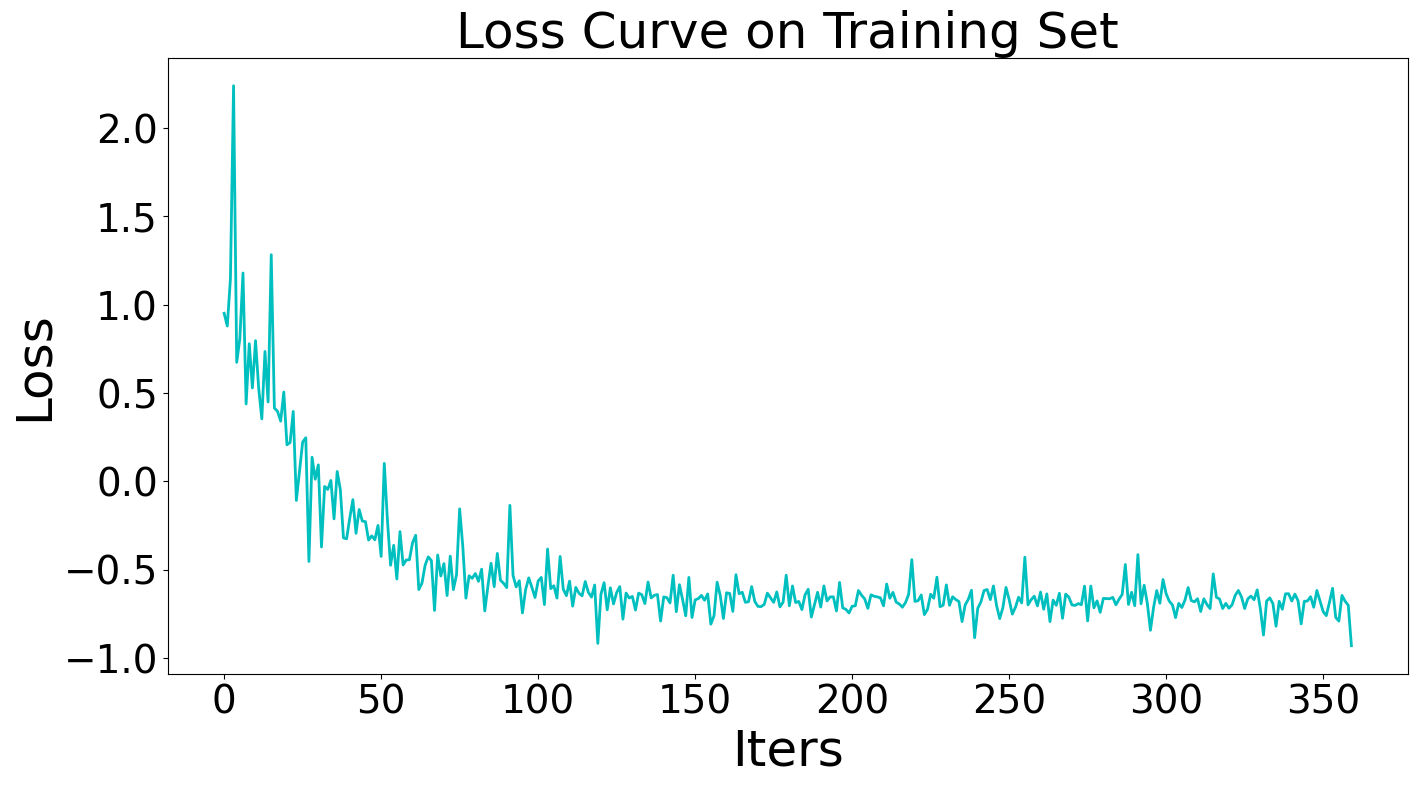

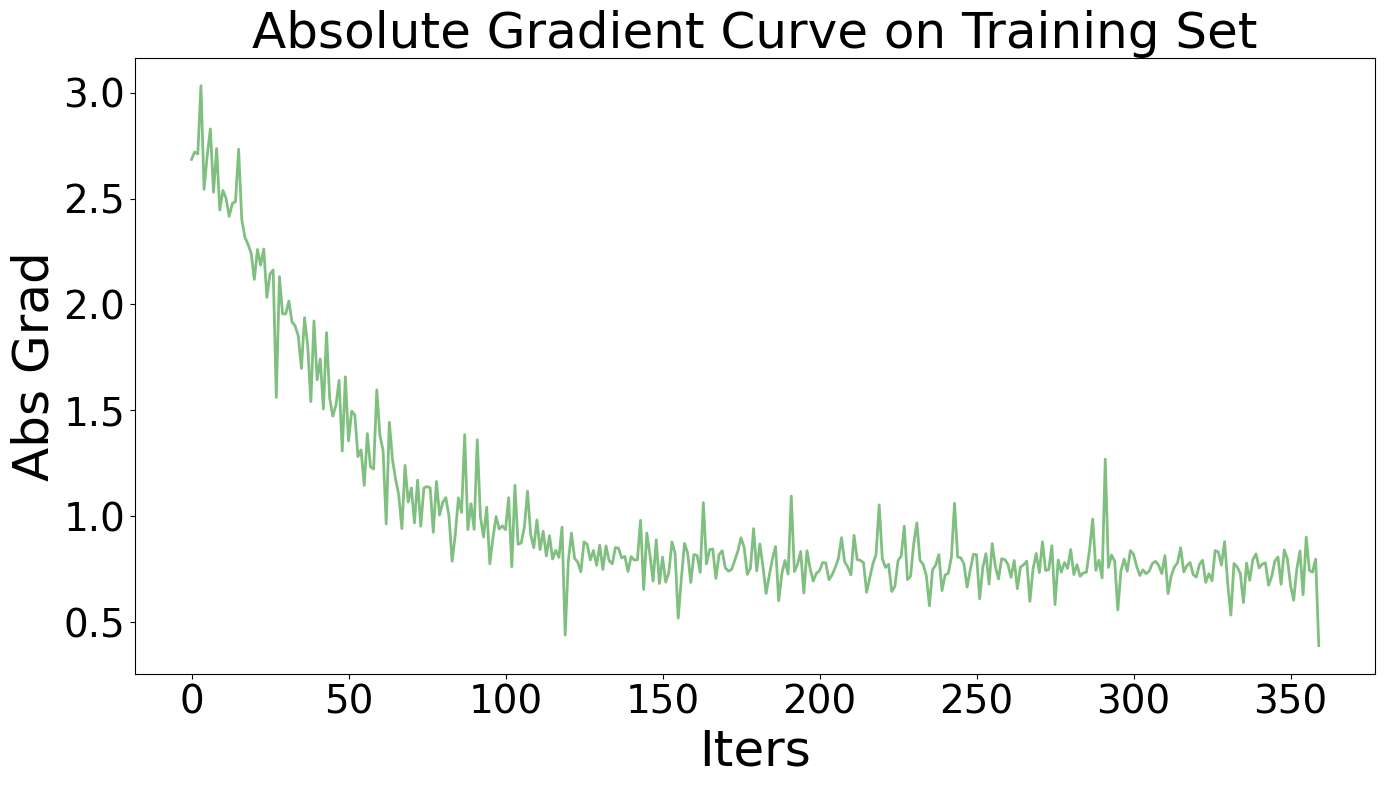

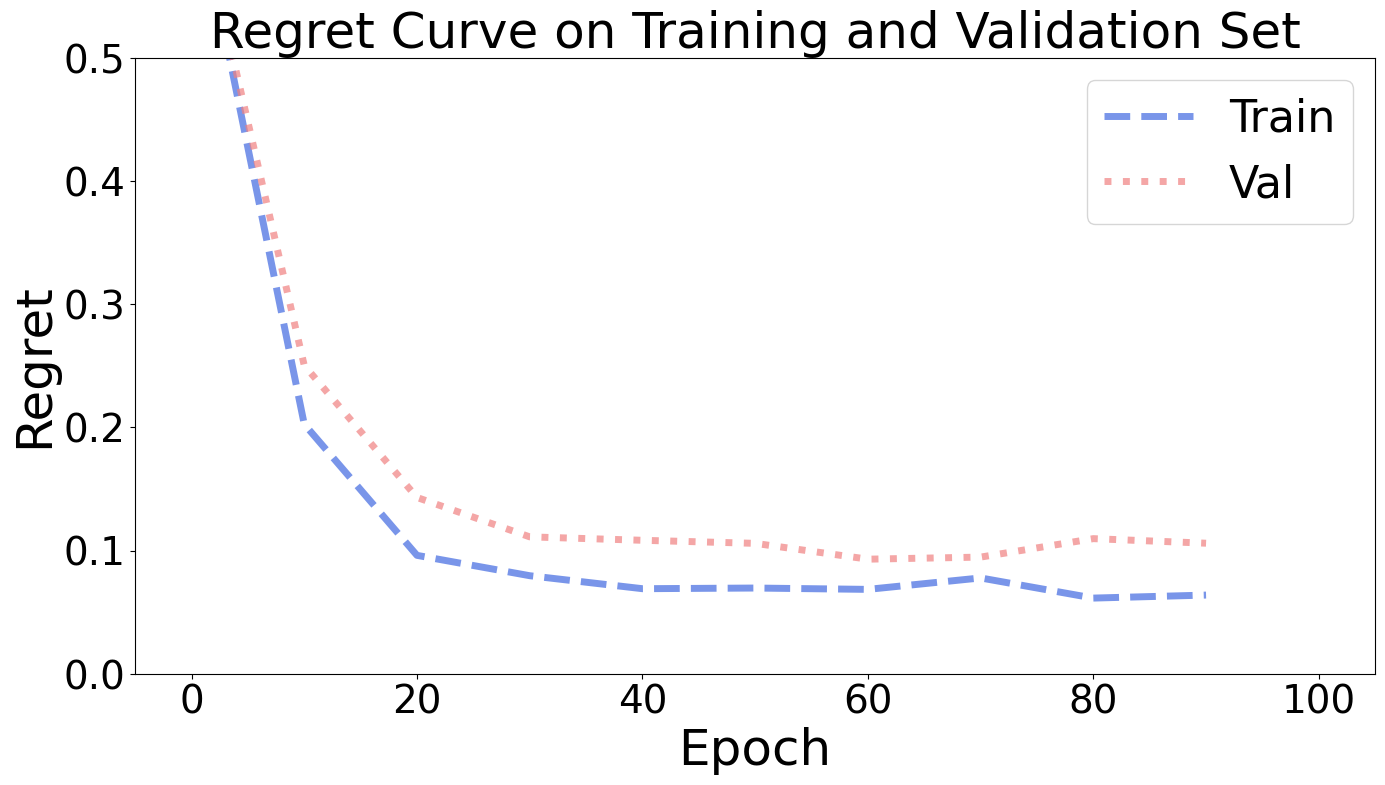

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  67.4291%, Val Regret:  67.6449%


Epoch    9, Loss:  -0.2289:  10%|█████▎                                               | 10/100 [00:10<01:32,  1.03s/it]

Epoch  10, Train Regret:  14.5496%, Val Regret:  18.1358%


Epoch   19, Loss:  -0.6464:  20%|██████████▌                                          | 20/100 [00:21<01:21,  1.02s/it]

Epoch  20, Train Regret:   9.6006%, Val Regret:  11.9671%


Epoch   29, Loss:  -0.5946:  30%|███████████████▉                                     | 30/100 [00:31<01:11,  1.02s/it]

Epoch  30, Train Regret:   6.2468%, Val Regret:  11.3214%


Epoch   39, Loss:  -0.5926:  40%|█████████████████████▏                               | 40/100 [00:42<01:01,  1.02s/it]

Epoch  40, Train Regret:   5.8805%, Val Regret:  11.6485%


Epoch   49, Loss:  -0.5642:  50%|██████████████████████████▌                          | 50/100 [00:52<00:51,  1.02s/it]

Epoch  50, Train Regret:   6.5702%, Val Regret:   9.9171%


Epoch   59, Loss:  -0.4020:  60%|███████████████████████████████▊                     | 60/100 [01:03<00:40,  1.02s/it]

Epoch  60, Train Regret:   7.3190%, Val Regret:  10.7697%


Epoch   69, Loss:  -0.5515:  70%|█████████████████████████████████████                | 70/100 [01:13<00:30,  1.02s/it]

Epoch  70, Train Regret:   7.8688%, Val Regret:  11.8706%


Epoch   79, Loss:  -0.5215:  80%|██████████████████████████████████████████▍          | 80/100 [01:23<00:20,  1.05s/it]


Epoch  80, Train Regret:   7.4025%, Val Regret:  11.7342%

Early Stop!

Evaluation:
Test Regret: 9.8088%
Training Elapsed Time: 0.99 Sec


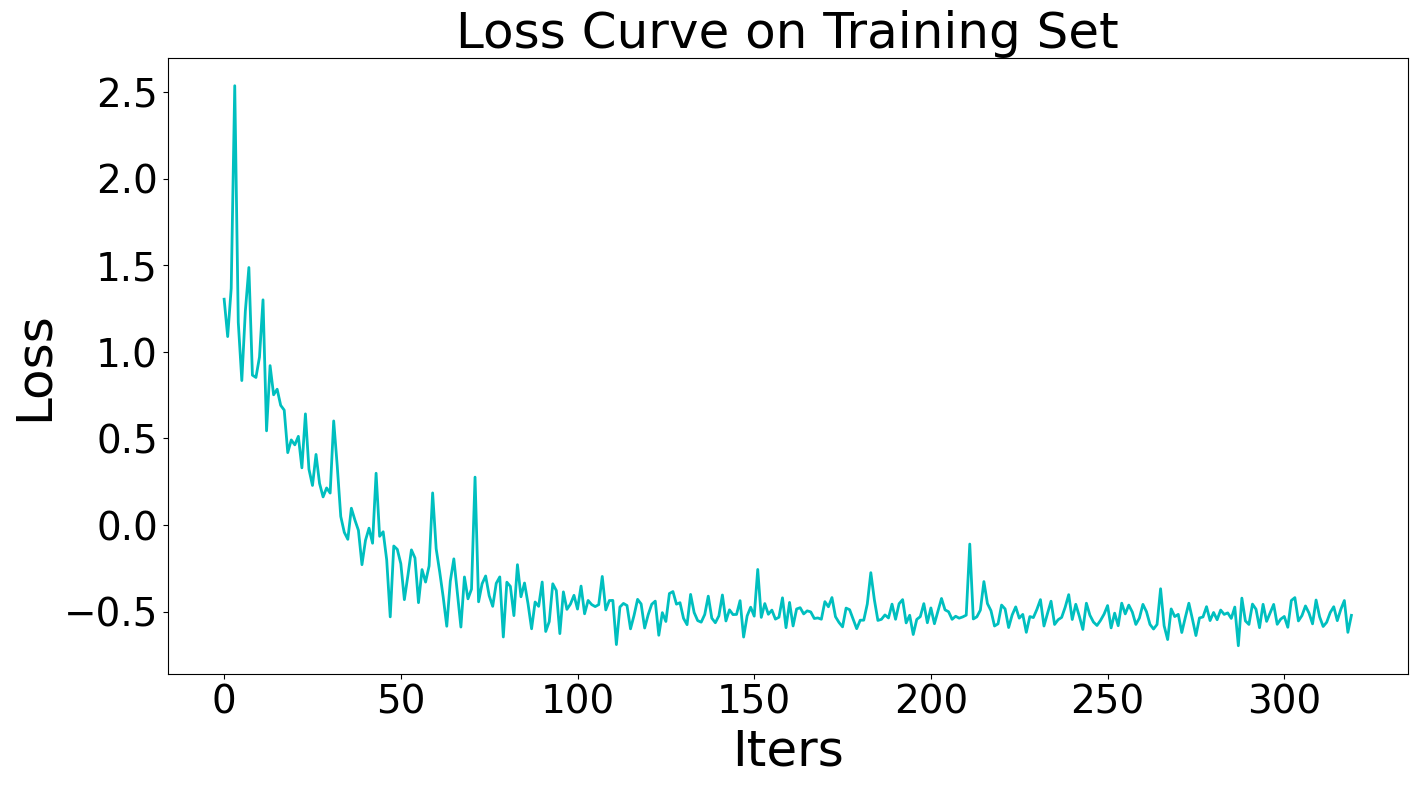

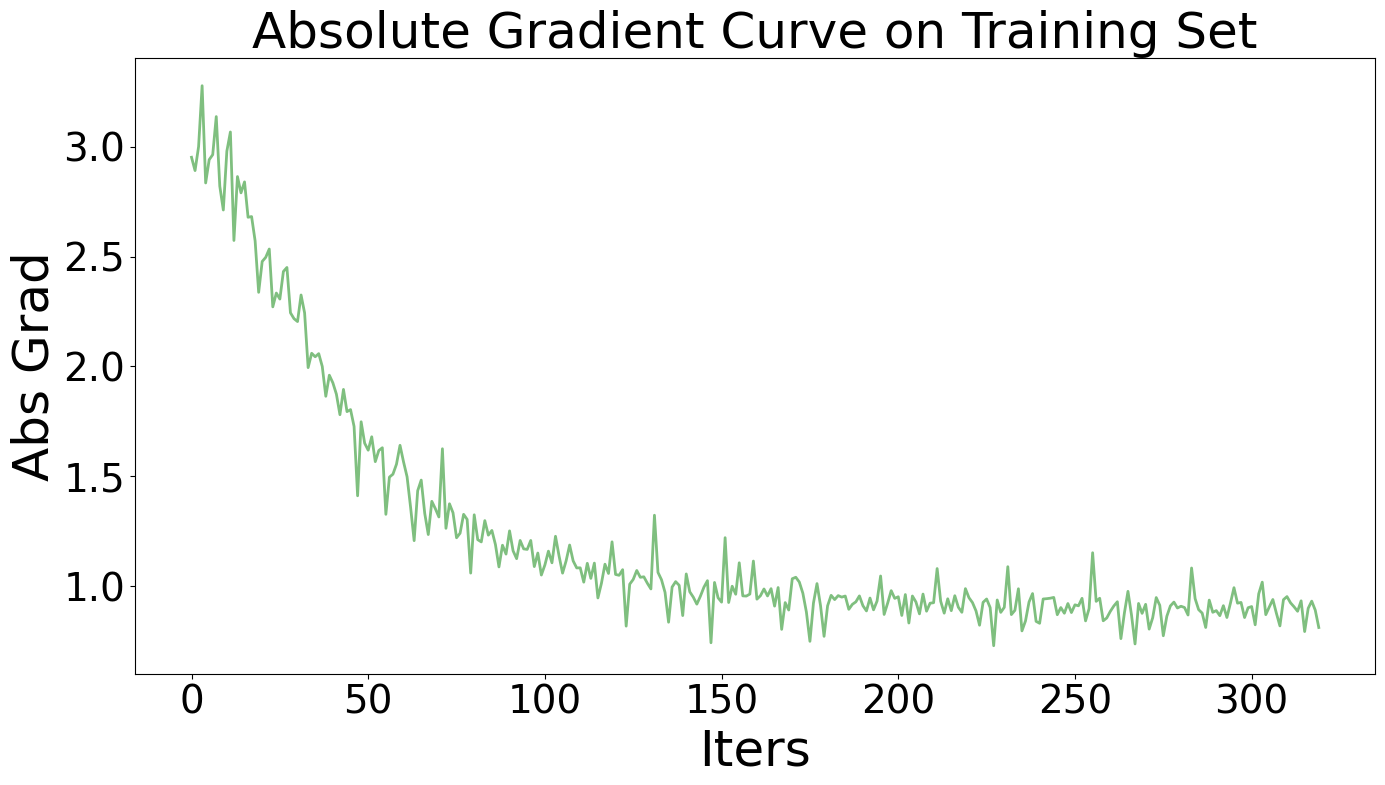

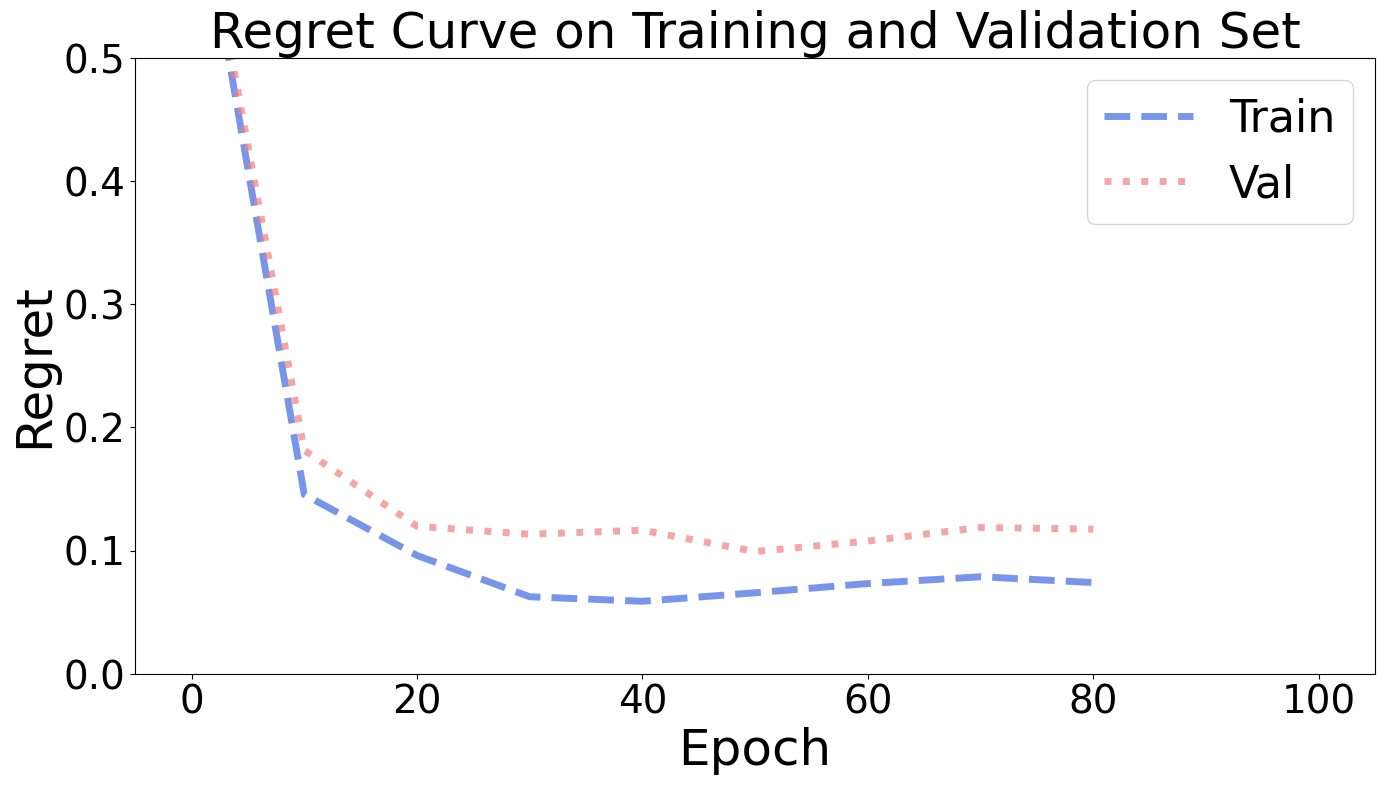

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch   0, Train Regret:  51.0379%, Val Regret:  52.6940%


Epoch    9, Loss:  -0.1146:  10%|█████▎                                               | 10/100 [00:12<01:44,  1.16s/it]

Epoch  10, Train Regret:  23.3432%, Val Regret:  28.3399%


Epoch   19, Loss:  -0.7514:  20%|██████████▌                                          | 20/100 [00:23<01:33,  1.17s/it]

Epoch  20, Train Regret:   9.4375%, Val Regret:  12.1045%


Epoch   29, Loss:  -0.7756:  30%|███████████████▉                                     | 30/100 [00:35<01:21,  1.17s/it]

Epoch  30, Train Regret:   7.0212%, Val Regret:  11.1237%


Epoch   39, Loss:  -0.7290:  40%|█████████████████████▏                               | 40/100 [00:47<01:10,  1.17s/it]

Epoch  40, Train Regret:   6.6550%, Val Regret:  10.0914%


Epoch   49, Loss:  -0.6979:  50%|██████████████████████████▌                          | 50/100 [00:59<00:58,  1.17s/it]

Epoch  50, Train Regret:   6.5754%, Val Regret:   9.6279%


Epoch   59, Loss:  -0.6911:  60%|███████████████████████████████▊                     | 60/100 [01:11<00:47,  1.18s/it]

Epoch  60, Train Regret:   6.7867%, Val Regret:  10.7232%


Epoch   69, Loss:  -0.7190:  70%|█████████████████████████████████████                | 70/100 [01:23<00:34,  1.17s/it]

Epoch  70, Train Regret:   6.3106%, Val Regret:  11.6038%


Epoch   79, Loss:  -0.6723:  80%|██████████████████████████████████████████▍          | 80/100 [01:35<00:23,  1.20s/it]


Epoch  80, Train Regret:   6.7638%, Val Regret:  10.1335%

Early Stop!

Evaluation:
Test Regret: 9.4148%
Training Elapsed Time: 12.66 Sec


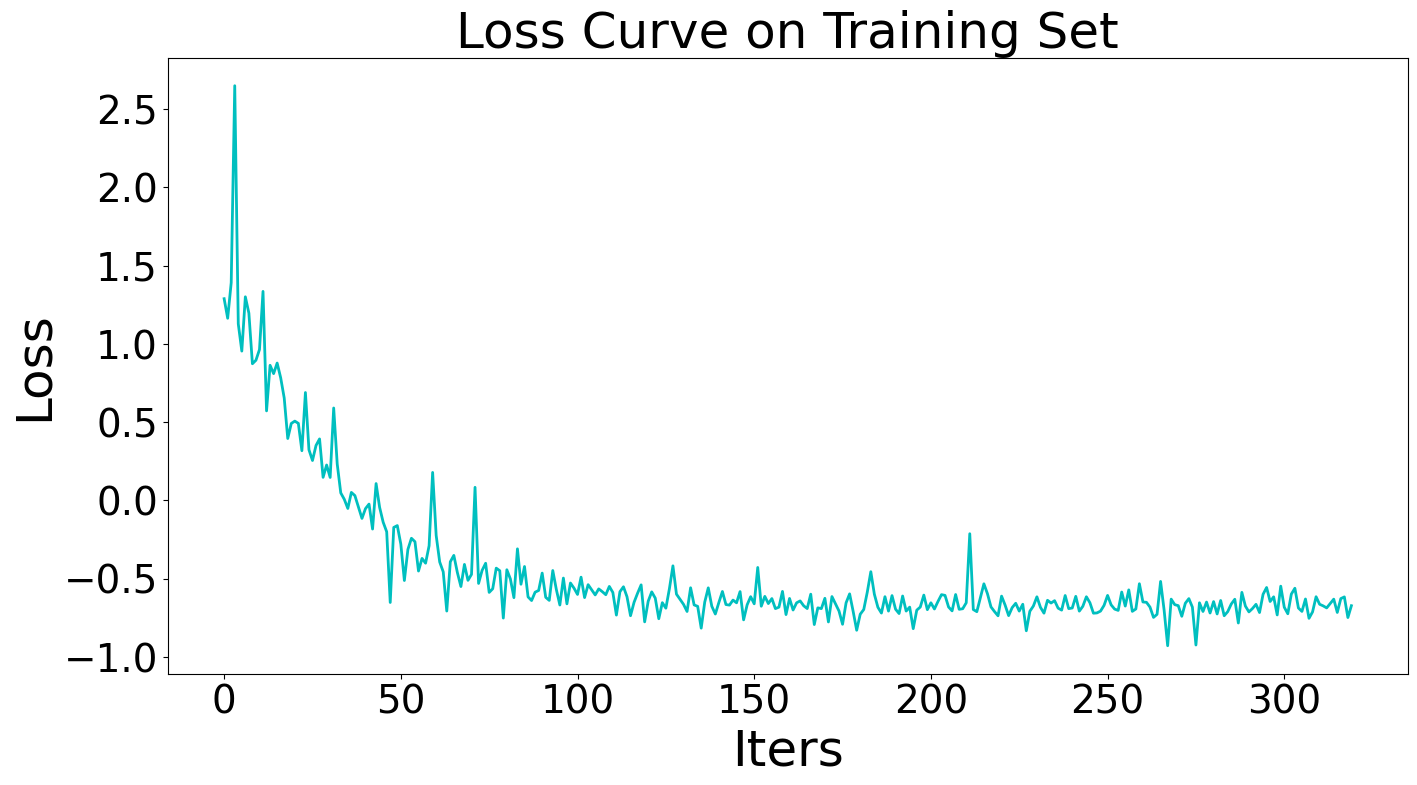

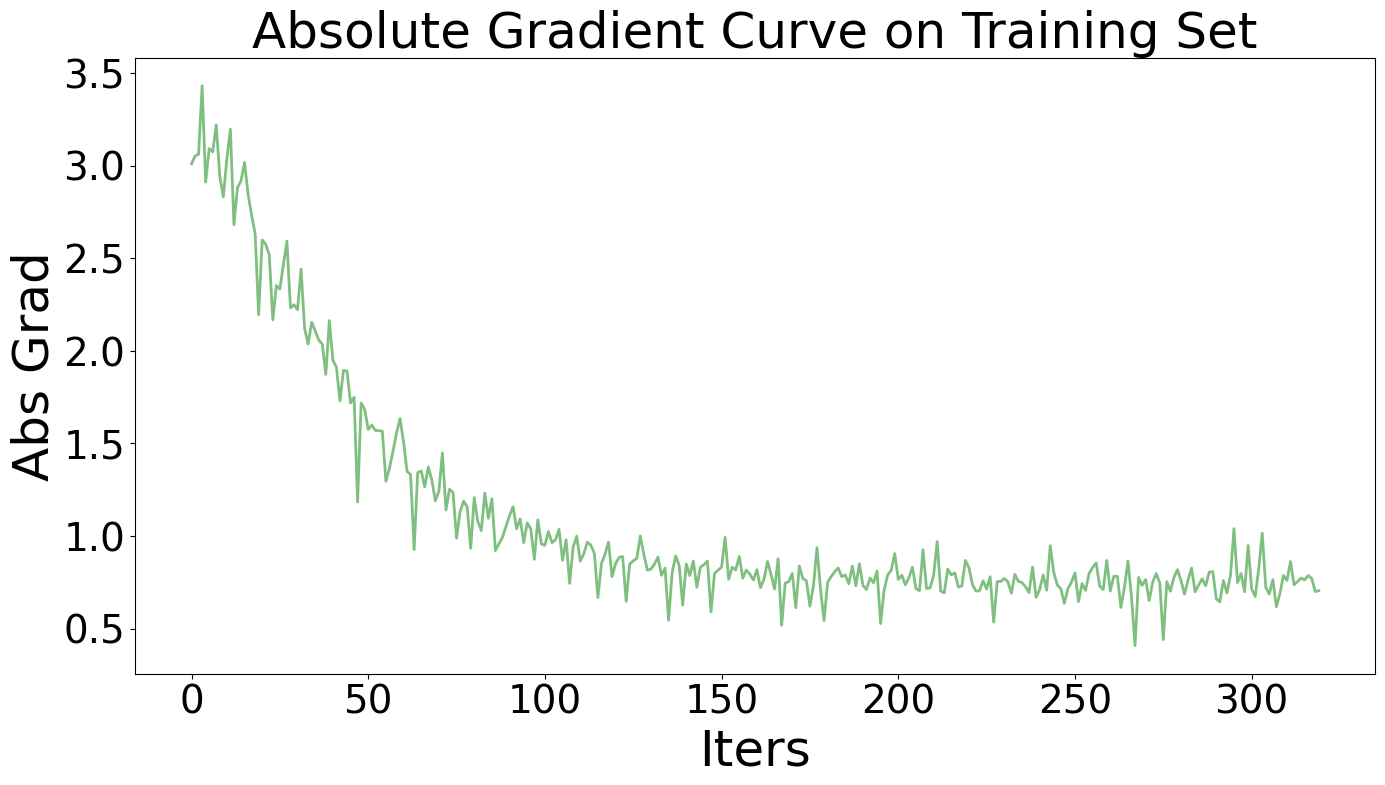

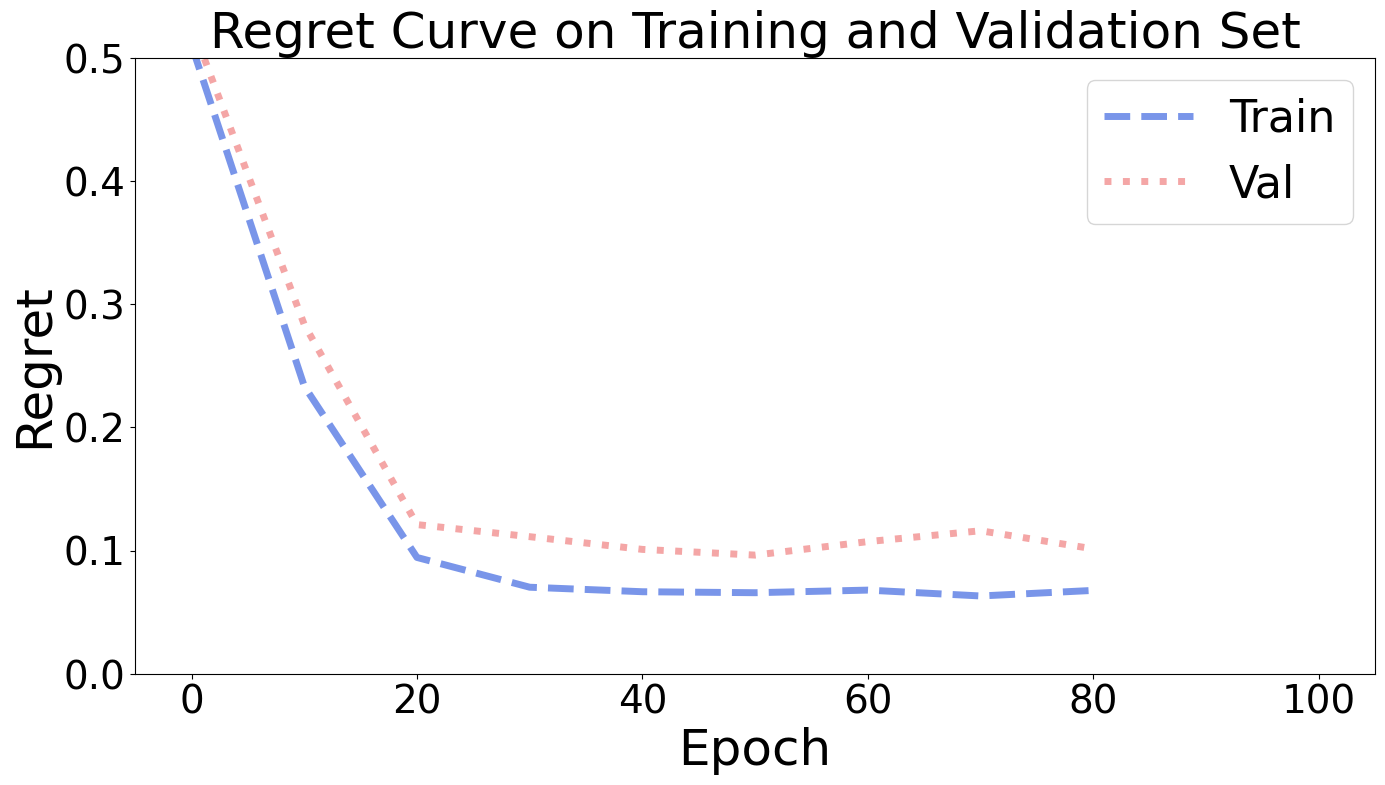

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)